# Burundi - Hydrologie Model

In [ ]:
'''
File name:              main.ipynb
Author:                 Oliver Carmignani
Date of creation:       2024-09-26
Python Version:         3.10
'''

# LOAD MODULES

In [1]:
from pomm import pomm
from pomm.pomm_helper import *
from pomm.pomm_vis import *

# INITIALIZE

## Variables and Constants

In [25]:
# Create object
station_name = 'Waga'
p = pomm.Pomm(station_name=station_name)
p.load_attributes()
p.load_input(num_c=3, soil_years=['2023'])

<tifffile.TiffPage 0 @11450542> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')


----------------------------------------------------------------------------------------------------
Load elevation:		 success
Load flowdirections:	 success
Load accumulation:	 success
Load catchment:		 success
Load soil:		 success


## Location

In [ ]:
hour = float(p.coordinates[0].split('°')[0])
minute = float(p.coordinates[0].split('°')[1].split('\'')[0])
second = float(p.coordinates[0].split('°')[1].split('\'')[1].split('"')[0])
x = hour + (minute + (second/60)) / 60
if p.coordinates[0][-1] == 'S': x *= -1
hour = float(p.coordinates[1].split('°')[0])
minute = float(p.coordinates[1].split('°')[1].split('\'')[0])
second = float(p.coordinates[1].split('°')[1].split('\'')[1].split('"')[0])
y = hour + (minute + (second/60)) / 60
if p.coordinates[1][-1] == 'W': y *= -1
df_loc = pd.DataFrame({
    'longitude': [y],
    'latitude': [x]
})
print(df_loc)
print_map(df_loc=df_loc, zoom=12)

## Tif files

### Cut

In [5]:
p.catchment = p.catchments[0]

In [ ]:
# Cut tif files
p.catchment_cut()
im_show(
    img=(p.elevation, p.flowdir, p.catchment, p.soil_v, p.accumulation_v, p.elevation_cutted*p.catchment_cutted, p.flowdir_cutted*p.catchment_cutted, p.catchment_cutted, p.soil_v_cutted*p.catchment_cutted, p.accumulation_v_cutted*p.catchment_cutted),
    title=('Elevation', 'Flowdirection', 'Catchment', 'Soil', 'Accumulation', 'Elevation', 'Flowdirection', 'Catchment', 'Soil', 'Accumulation'),
    s_shape=[2,5],
    cmap=('Blues', 'rainbow', 'Greys', 'Greens', 'ocean', 'Blues', 'rainbow', 'Greys', 'Greens', 'ocean'),
    bbox=(p.x_min, p.x_max, p.y_min, p.y_max),
    bbox_on=(1,1,1,1,1,0,0,0,0,0),
    mode=('img','img','img','img','img','img','img','img','img','img'),
    name='Inputs overview',
    vis=True
)

In [ ]:
print(f'{"Number of pixxels:":<25}{p.catchment_cutted.sum()}')
print(f'{"Resolution per pixxel:":<25}{30} m')
print(f'{"Calculated Area:":<25}{round(p.catchment_cutted.sum()*30*30 / 1000 / 1000, 2)} km²')
# print(f"{value1:<20}{value2}")

In [ ]:
plt.figure(figsize=[10,3])
y = p.elevation_cutted.flatten()
y = y[np.logical_not(np.isnan(y))]
y = np.sort(y)
x = np.arange(y.shape[0])
plt.ylabel('meter above sea level')

# Define the highest and lowest colors
lowest_color = (125, 216, 167)
highest_color = (0, 0, 0)
# Normalize the heights to map them to colors
normalized_heights = (y - y.min()) / (y.max() - y.min())
# Interpolate between the highest and lowest colors based on the normalized heights
colors = []
for h in normalized_heights:
    r = int((1 - h) * highest_color[0] + h * lowest_color[0])
    g = int((1 - h) * highest_color[1] + h * lowest_color[1])
    b = int((1 - h) * highest_color[2] + h * lowest_color[2])
    colors.append((r / 255, g / 255, b / 255))  # Normalize to [0, 1]

plt.scatter(x, y, c=colors)
plt.savefig('./output/plots/m above sea level.png', dpi=300, bbox_inches='tight')

### Flow Direction

In [9]:
# # Calculate hydraulic length
# p.hydraulic_length(amount=5000)

In [10]:
# # Make temporary images which also contains the longest paths
# steps_tmp = p.steps_to_intake.copy()
# steps_tmp[p.stepsMaxPath==1] = 0
# distance_tmp = p.distance_to_intake.copy()
# distance_tmp[p.distanceMaxPath==1] = 0
# im_show(
#     (steps_tmp, distance_tmp),
#     title=[
#     f'Most steps\nSteps: {p.steps_to_intake[p.stepsMaxX,p.stepsMaxY][0]} ; Distance: {p.distance_to_intake[p.stepsMaxX,p.stepsMaxY][0]} m',
#     f'Highest distance (hydraulic length)\nSteps: {p.steps_to_intake[p.distanceMaxX,p.distanceMaxY][0]} ; Distance: {p.distance_to_intake[p.distanceMaxX,p.distanceMaxY][0]} m'
#     ],
#     s_shape=[1,2],
#     name='Hydraulic length'
# )

### Accumulation

In [ ]:
# Main and Secondary river
%matplotlib inline
p.river_hirarchy()
im_show(
    (p.accumulation_cutted, p.accumulation_v_cutted, p.rs, p.rs_v), 
    title=['Accumulation', 'sqrt(Accumulation)', 'Main- & Secondary River', 'Main- & Secondary River'], 
    s_shape=[2,2], 
    cmap=('ocean','ocean','ocean','ocean'),
    name='Accumulation'
)

### Soil

In [ ]:
"""
Band Information:
    Link:           https://www.usgs.gov/faqs/what-are-best-landsat-spectral-bands-use-my-research?qt-news_science_products=0#qt-news_science_products
Used Landsat:
    Description:    Landsat 8, Collection 1, Tier 1 + Real Time
    ID:             LANDSAT/LC08/C01/T1_RT
    Link:           https://developers.google.com/earth-engine/guides/landsat#landsat-collection-structure

Summary:
    Band1:          coastal and aerosol studies
    Band2:          distinguishing soil from vegetation and deciduous from coniferous vegetation
    Band3:          assessing plant vigor
    Band4:          discriminates vegetation slopes
    Band5:          emphasizes biomass content and shorelines
    Band6:          discriminates moisture content of soil and vegetation
    Band7:          improved moisture content of soil and vegetation
    # Band8:          15m res
    # Band9:          Improved detection of cirrus cloud contamination
    # Band10:         100m res
    # Band11:         100m res
"""

In [ ]:
"""
Collection 2
https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2#bands
"""

In [14]:
# plot_tensor(p.soils[0])

In [15]:
p.soil_v_cutted *= 1000 # In Collection 2, the wavelengths are used. Before it was multyplied by 1000

In [ ]:
p.soil_v_cutted[p.catchment_cutted==0] = np.nan
im_show(
    (p.soil_v_cutted),
    title=[
    'Soil (input)'
    ],
    s_shape=[1,1],
    cmap=('Greens', 'Greens', 'Greens', 'Greens'),
    name='Soil input'
)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(20,7))
# Define the colors at the extremes
color_low = (125/255, 216/255, 167/255) # (125, 216, 167) in RGB, normalized to [0, 1]
color_high =  (0,0,0) # Black
# Create a list of color points
colors = [color_low, color_high]
# Create a list of color values that range from 0 to 1
# This corresponds to the values you want to map to the colormap
values = [0, 1]
# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", list(zip(values, colors)))
plt.imshow(p.soil_v_cutted, cmap=custom_cmap)
plt.savefig('./output/plots/Soil Frigg color.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Plot dist of soil values
CN_borders = np.array([100, 160, 225, 290])
plt.hist(p.soil_v_cutted)
for CN_border in CN_borders:    
    plt.axvline(x=CN_border, color='red', linestyle='--')
plt.title('Soil hist')
plt.savefig('./output/plots/Soil hist.png', dpi=300, bbox_inches='tight')
plt.show()

#### Curve-Number and Absorbtion

In [ ]:
# Transform soil map to Curve-Number and Absorbtion
p.Generate_CN(CN_borders=CN_borders)
p.Generate_Sabs(Sabs_borders=CN_borders)
im_show(
    (p.soil_v_cutted, p.CN_init, p.Sabs_init),
    title=[
    'Soil (input)',
    'Curve Number (CN)\nThe darker, the higher runoff potential',
    'Absorbtion (Sabs)\nThe darker, the higher the absorbtion',
    ],
    s_shape=[1,3],
    cmap=('Greens', 'Greens', 'Greens', 'Greens'),
    name='CN-Sabs'
)

#### Mannings-Coefficient

In [ ]:
# Transform Curve Number to Mannings-Coefficient
# p.Generate_MC(mcs_overland=[500,200], mcs_subsurface=[1000,500])
p.Generate_MC(mcs_overland=[100,50], mcs_subsurface=[200,100])
# p.Generate_MC(mcs_overland=[150,100], mcs_subsurface=[250,150])
# p.Generate_MC(mcs_overland=[0.5,0.25], mcs_subsurface=[1,0.5])
im_show(
    (p.mc_overland, p.mc_subsurface),
    title=[
    'Mannings Coefficient Overland',
    'Mannings Coefficient Subsurface'
    ],
    s_shape=[1,2],
    cmap=('Greens', 'Greens'),
    name='Mannings Coefficient'
)

## Rainfall

In [ ]:
waga = pd.read_excel('./data/Gisozi_Ruvyironza_Gitega.xlsx')
waga.columns = ['station_name', 'year', 'month', 'day', 'precip']
waga_1 = waga[waga.station_name=='GISOZI'].copy()
waga_2 = waga[waga.station_name=='GITEGA (Aerodrome)'].copy()
waga_3 = waga[waga.station_name=='RUVYIRONZA'].copy()
waga_1.reset_index(inplace=True, drop=True)
waga_2.reset_index(inplace=True, drop=True)
waga_3.reset_index(inplace=True, drop=True)
waga_1['date'] = [datetime.strptime(str(waga_1.year[i]) + '-' + str(waga_1.month[i]) + '-' + str(waga_1.day[i]), '%Y-%m-%d').date() for i in range(waga_1.shape[0])]
waga_2['date'] = [datetime.strptime(str(waga_2.year[i]) + '-' + str(waga_2.month[i]) + '-' + str(waga_2.day[i]), '%Y-%m-%d').date() for i in range(waga_2.shape[0])]
waga_3['date'] = [datetime.strptime(str(waga_3.year[i]) + '-' + str(waga_3.month[i]) + '-' + str(waga_3.day[i]), '%Y-%m-%d').date() for i in range(waga_3.shape[0])]
waga_1.set_index('date', inplace=True)
waga_2.set_index('date', inplace=True)
waga_3.set_index('date', inplace=True)

print(waga_1.shape)
print(waga_2.shape)
print(waga_3.shape)

date_range = pd.date_range(start='2009-01-01', end='2023-12-31', freq='D')
date_range = pd.DataFrame(data={'Zeros': 0}, index=date_range)
waga_concat = date_range.merge(waga_1.precip, how='outer', left_index=True, right_index=True)
waga_concat = waga_concat.merge(waga_2.precip, how='outer', left_index=True, right_index=True)
waga_concat = waga_concat.merge(waga_3.precip, how='outer', left_index=True, right_index=True)
waga_concat.columns = ['drop', 'GISOZI', 'GITEGA (Aerodrome)', 'RUVYIRONZA']
waga_concat = waga_concat[['GISOZI', 'GITEGA (Aerodrome)', 'RUVYIRONZA']]
waga_concat = create_timefeatures(waga_concat)

print()
print(waga_concat.shape)

In [ ]:
plot_overview(df=waga_concat, key='GISOZI', title='GISOZI', ylabel='mm/d')
plot_overview(df=waga_concat, key='GITEGA (Aerodrome)', title='GITEGA (Aerodrome)', ylabel='mm/d')
plot_overview(df=waga_concat, key='RUVYIRONZA', title='RUVYIRONZA', ylabel='mm/d')

In [ ]:
feature_target_relation(df=waga_concat, key='GISOZI', location='GISOZI', name='GISOZI', ylabel='mm/d', feature='month')
feature_target_relation(df=waga_concat, key='GITEGA (Aerodrome)', location='GITEGA (Aerodrome)', name='GITEGA (Aerodrome)', ylabel='mm/d', feature='month')
feature_target_relation(df=waga_concat, key='RUVYIRONZA', location='RUVYIRONZA', name='Precip', ylabel='mm/d', feature='month')

In [ ]:
plot_loess(df=waga_concat, key='GISOZI', title='GISOZI -- deviations from the mean average annual precipitation')
plot_loess(df=waga_concat, key='GITEGA (Aerodrome)', title='GITEGA (Aerodrome) -- deviations from the mean average annual precipitation')
plot_loess(df=waga_concat, key='RUVYIRONZA', title='RUVYIRONZA -- deviations from the mean average annual precipitation', name='RUVYIRONZA -- deviations from the mean average annual precipitation')

## Runoff

### Ruvyironza

In [25]:
waga_ruvyironza = pd.read_excel('./data/Niveaux_RUVYIRONZA.xlsx')
waga_ruvyironza.columns = ['station_name', 'year', 'month', 'day', 'level']
waga_ruvyironza['date'] = [datetime.strptime(str(waga_ruvyironza.year[i]) + '-' + str(waga_ruvyironza.month[i]) + '-' + str(waga_ruvyironza.day[i]), '%Y-%m-%d').date() for i in range(waga_ruvyironza.shape[0])]
waga_ruvyironza.set_index('date', inplace=True)
date_range = pd.date_range(start='1985-09-01', end='1997-12-31', freq='D')
date_range = pd.DataFrame(data={'Zeros': 0}, index=date_range)
waga_ruvyironza_concat = date_range.merge(waga_ruvyironza.level, how='outer', left_index=True, right_index=True)
waga_ruvyironza_concat = waga_ruvyironza_concat[['level']]
waga_ruvyironza_concat = create_timefeatures(waga_ruvyironza_concat)

In [ ]:
plot_overview(df=waga_ruvyironza_concat, key='level', title='Ruvyironza waterlevel', ylabel='m')
plot_fdc(df=waga_ruvyironza_concat, key='level', ylabel='m', log=False, title='FDC Ruvyironza waterlevel')

In [ ]:
feature_target_relation(df=waga_ruvyironza_concat, key='level', location='Ruvyironza', name='Ruvyironza waterlevel by month', ylabel='m', feature='month')
plot_loess(df=waga_ruvyironza_concat, key='level', title='Ruvyironza -- deviations from the mean average annual waterlevel', name='Ruvyironza -- deviations from the mean average annual waterlevel')

### Waga

In [28]:
waga_nkondo = pd.read_excel('./data/Niveaux_NKONDO.xlsx')
waga_nkondo.columns = ['station_name', 'year', 'month', 'day', 'level']
waga_nkondo['date'] = [datetime.strptime(str(waga_nkondo.year[i]) + '-' + str(waga_nkondo.month[i]) + '-' + str(waga_nkondo.day[i]), '%Y-%m-%d').date() for i in range(waga_nkondo.shape[0])]
waga_nkondo.set_index('date', inplace=True)
date_range = pd.date_range(start='2009-01-01', end='2023-12-31', freq='D')
date_range = pd.DataFrame(data={'Zeros': 0}, index=date_range)
waga_nkondo_concat = date_range.merge(waga_nkondo.level, how='outer', left_index=True, right_index=True)
waga_nkondo_concat = waga_nkondo_concat[['level']]
waga_nkondo_concat = create_timefeatures(waga_nkondo_concat)

In [ ]:
plot_overview(df=waga_nkondo_concat, key='level', title='Waga waterlevel', ylabel='m')
plot_fdc(df=waga_nkondo_concat, key='level', ylabel='m', log=False, title='FDC Waga waterlevel')

In [ ]:
feature_target_relation(df=waga_nkondo_concat, key='level', location='Waga', name='Waga waterlevel by month', ylabel='m', feature='month')
plot_loess(df=waga_nkondo_concat, key='level', title='Waga -- deviations from the mean average annual waterlevel')

In [31]:
# waga_nkondo_concat['runoff'] = 

In [32]:
'a * (H-H0)**b'
a = 11.088
b = 0.8579
H = waga_nkondo_concat.level
H0 = 0
waga_nkondo_concat['runoff'] = calc_Q(a,b,H,H0)

In [ ]:
plot_overview(df=waga_nkondo_concat, key='runoff', title='Waga waterlevel', ylabel='m³/s')
plot_fdc(df=waga_nkondo_concat, key='runoff', ylabel='m³/s', log=False, title='FDC Waga waterlevel')

### Simu

In [34]:
simu = pd.read_excel('./data/Simu_Hydrology data.xlsx', sheet_name='Simu_Flow')
simu.columns = ['date', 'flow', 'm']
simu = simu[['date', 'flow']]
simu.set_index('date', inplace=True)
simu = create_timefeatures(simu)

In [ ]:
plot_overview(df=simu, key='flow', title='Simu flow', ylabel='?')
plot_fdc(df=simu, key='flow', ylabel='?', log=False, title='FDC Simu flow')

In [ ]:
feature_target_relation(df=simu, key='flow', location='Simu', name='Simu flow by month', ylabel='?', feature='month')
plot_loess(df=simu, key='flow', title='Simu -- deviations from the mean average annual flow')

### Sipi

In [37]:
sipi = pd.read_excel('./data/Sipi_Hydrology data.xlsx', sheet_name='Sipi_Flow')
sipi.columns = ['date', 'flow', 'm']
sipi = sipi[['date', 'flow']]
sipi.set_index('date', inplace=True)
sipi = create_timefeatures(sipi)

In [ ]:
plot_overview(df=sipi, key='flow', title='Sipi flow', ylabel='?')
plot_fdc(df=sipi, key='flow', ylabel='?', log=False, title='FDC Sipi flow')

In [ ]:
feature_target_relation(df=sipi, key='flow', location='Sipi', name='Sipi flow by month', ylabel='?', feature='month')
plot_loess(df=sipi, key='flow', title='Sipi -- deviations from the mean average annual flow')

### Sironko

In [40]:
sironko = pd.read_excel('./data/Sironko_Hydrology data.xlsx', sheet_name='Sironko_Flow')
sironko.columns = ['date', 'flow', 'm']
sironko = sironko[['date', 'flow']]
sironko.set_index('date', inplace=True)
sironko = create_timefeatures(sironko)

In [ ]:
plot_overview(df=sironko, key='flow', title='Sironko flow', ylabel='?')
plot_fdc(df=sironko, key='flow', ylabel='?', log=False, title='FDC Sironko flow')

In [ ]:
feature_target_relation(df=sironko, key='flow', location='Sironko', name='Sironko flow by month', ylabel='?', feature='month')
plot_loess(df=sironko, key='flow', title='Sironko -- deviations from the mean average annual flow')

## Temperature

## ERA5

### Load

In [2]:
try:
    read_nc('./data/ERA5/Waga_ERA5_' + '2015' + '_' + '01' + '.nc', info=True)
except:
    read_nc('./data/ERA5/Waga_ERA5_' + '2015' + '_' + '1' + '.nc', info=True)


DATASET----------------------------------------------------------------------------------------------------
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    history: 2024-10-05T05:08 GRIB to CDM+CF via cfgrib-0.9.14.1/ecCodes-2.36.0 with {"source": "data.grib", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
    dimensions(sizes): valid_time(744), latitude(4), longitude(3)
    variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 skt(valid_time, latitude, longitude), float32 t2m(valid_time, latitude, longitude), float32 tp(valid_time, latitude, longitude), float32 sf(valid_time, latitud


DATASET----------------------------------------------------------------------------------------------------
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    history: 2024-10-09T08:51 GRIB to CDM+CF via cfgrib-0.9.14.1/ecCodes-2.36.0 with {"source": "data.grib", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
    dimensions(sizes): valid_time(744), latitude(4), longitude(3)
    variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 skt(valid_time, latitude, longitude), float32 t2m(valid_time, latitude, longitude), float32 tp(valid_time, latitude, longitude), float32 sf(valid_time, latitud

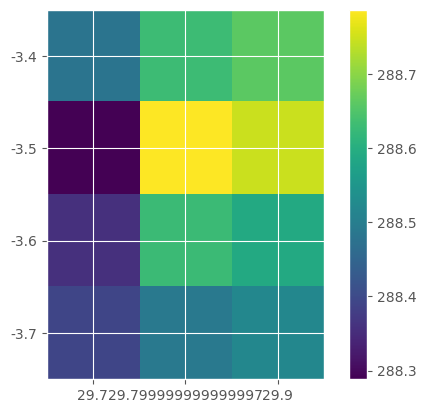

In [3]:
df_era5, lat_era5, lon_era5 = load_ERA5(
    lat_index=2,
    lon_index=1,
    months=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    years=[str(year) for year in range(2002, 2024)],
    plot_nc=plot_nc,
    plant_name='Waga'
)

### Rainfall

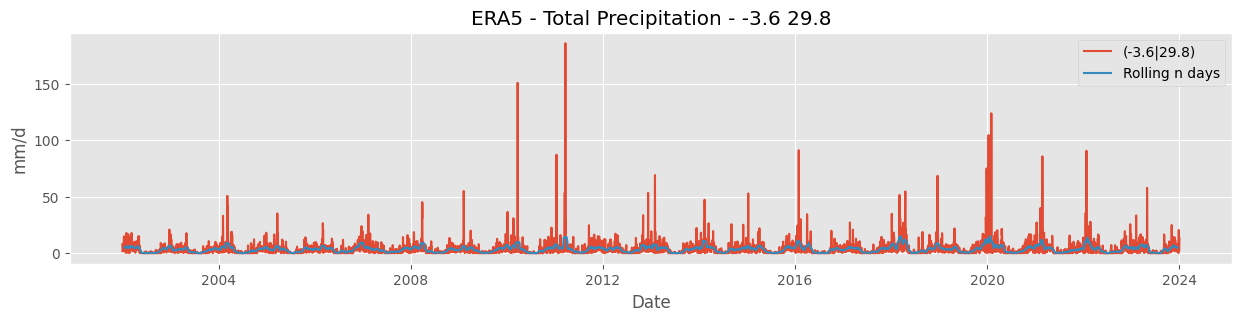

In [4]:
## CALC DAILY SUM OF PRECIP

# HOURLY DERIVATIVE
tp = df_era5['tp'].diff() * 1000
tp = create_timefeatures(pd.DataFrame(tp))
tp['tp'][tp['hour']==1] = df_era5['tp'][df_era5['hour']==1]

# DAILY SUM
tp = (tp.groupby(pd.Grouper(freq='1D')).sum()['tp'])
tp = create_timefeatures(pd.DataFrame(tp))
tp = tp.dropna()

## INIT PLOT
fig = plt.figure(figsize=[15,3])

## PLOT PIXXEL DATA
plt.plot(tp['tp'], label=f'({lat_era5}|{lon_era5})')

## ROLLING
tmp = tp['tp'].rolling(30, center=True).mean()
tmp = create_timefeatures(pd.DataFrame(tmp))
plt.plot(tmp['tp'], label=f'Rolling n days')

## APPEARANCE
plt.title(f'ERA5 - Total Precipitation - {lat_era5} {lon_era5}')
plt.xlabel('Date')
plt.ylabel('mm/d')
plt.legend()
plt.show()

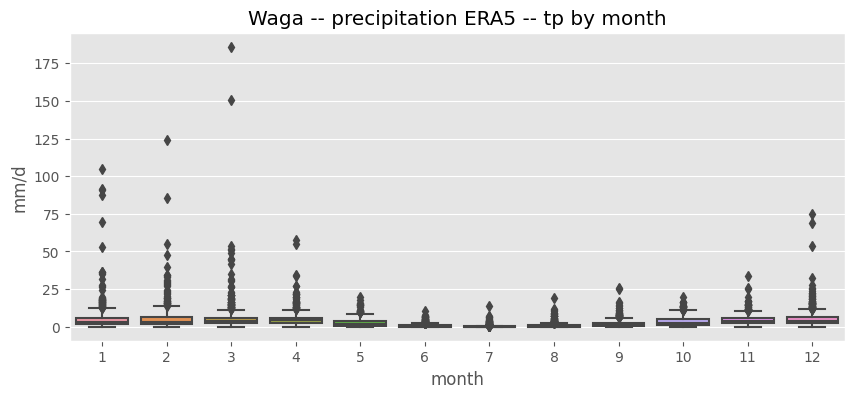

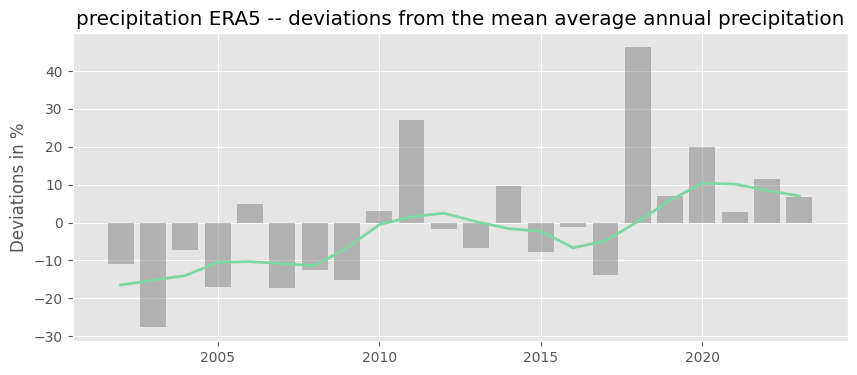

In [5]:
feature_target_relation(df=tp[tp.index>='2002-01-01'], key='tp', location='Waga', name='precipitation ERA5', ylabel='mm/d', feature='month')
plot_loess(df=tp[tp.index>='2002-01-01'], key='tp', title='precipitation ERA5 -- deviations from the mean average annual precipitation', name='precipitation ERA5 -- deviations from the mean average annual precipitation')

### Runoff

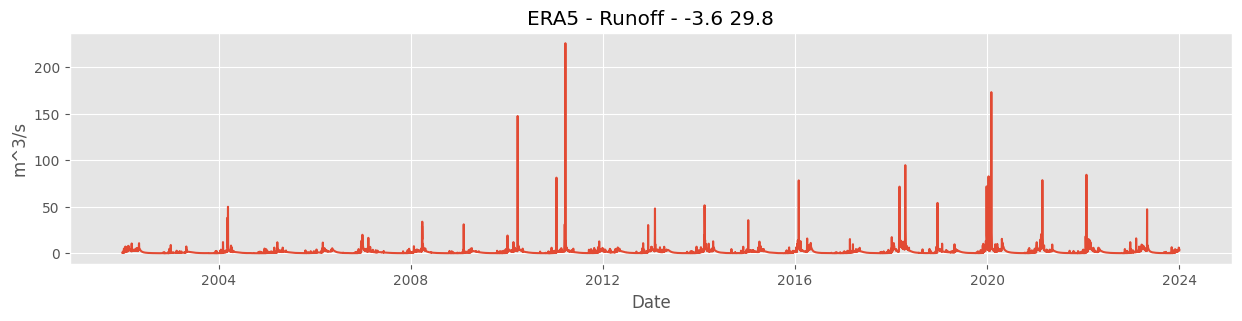

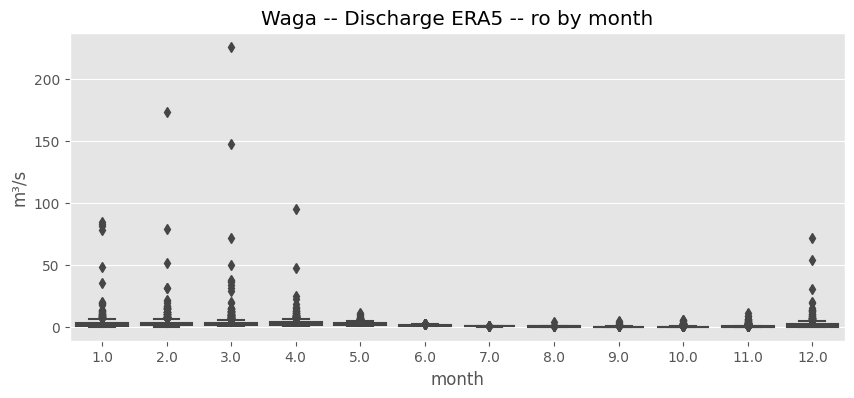

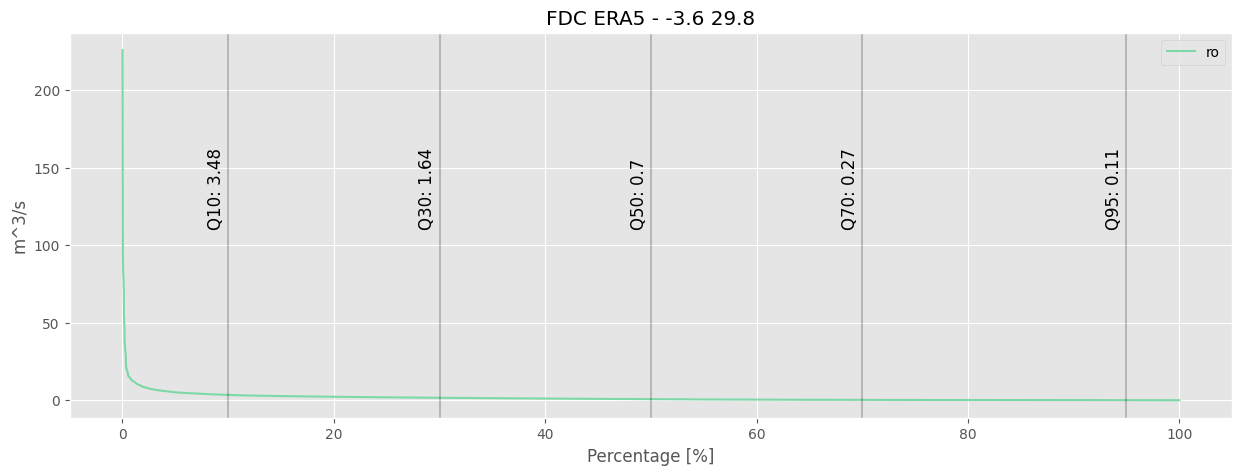

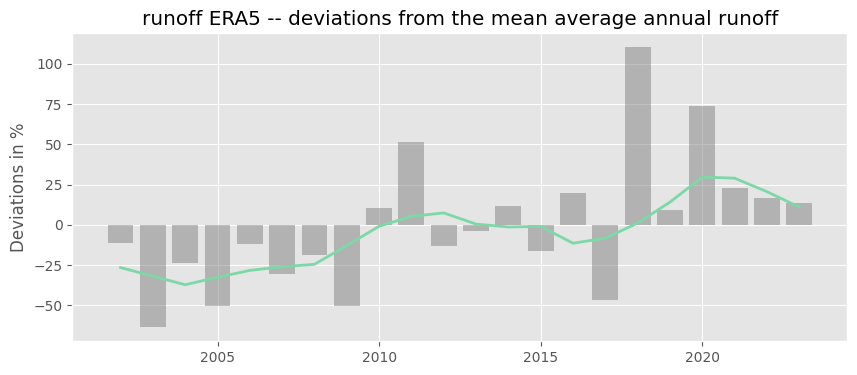

In [6]:
## CALC DAILY SUM OF RUNOFF

# ro = (df_era5.groupby(pd.Grouper(freq='1D')).sum()['ro'])
ro = df_era5['ro'].diff()
ro = create_timefeatures(pd.DataFrame(ro))
ro['ro'][ro['hour']==1] = df_era5['ro'][df_era5['hour']==1]
ro.ro = ro.ro * 11000 * 11000 / 60 / 60
ro = ro.groupby(pd.Grouper(freq='1D')).mean()
ro = ro.dropna()

plt.figure(figsize=[15,3])
plt.plot(ro.ro)
plt.title(f'ERA5 - Runoff - {lat_era5} {lon_era5}')
plt.xlabel('Date')
plt.ylabel('m^3/s')
plt.show()

feature_target_relation(df=ro[ro.index>='2002-01-01'], key='ro', location='Waga', name='Discharge ERA5', ylabel='m³/s', feature='month')
plot_fdc(df=ro, key='ro', ylabel='m^3/s', log=False, title=f'FDC ERA5 - {lat_era5} {lon_era5}')
plot_loess(df=ro, key='ro', title='runoff ERA5 -- deviations from the mean average annual runoff', name='runoff ERA5 -- deviations from the mean average annual runoff')

In [7]:
# plt.figure(figsize=[15,3])
# plt.plot(ro.ro)
years = []
sums = []
for year in ro.year.unique():
    years.append(year)
    sums.append(ro[ro.year==year]['ro'].sum())

### Surface Runoff

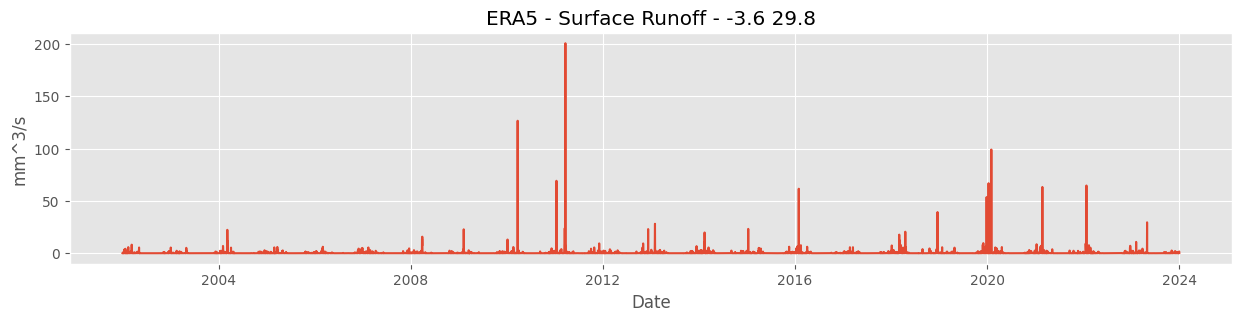

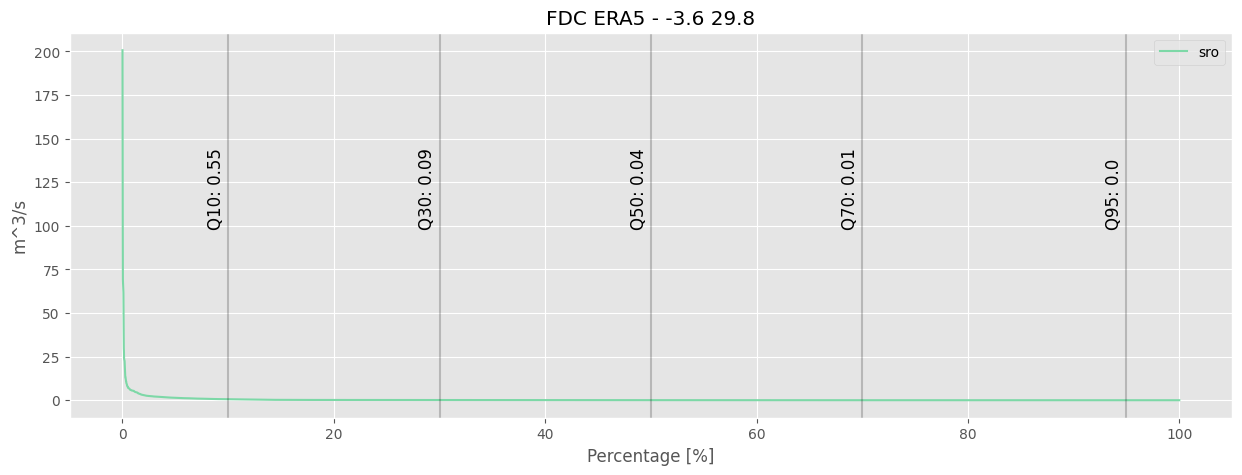

In [8]:
## CALC DAILY SUM OF RUNOFF
# ro = (df_era5.groupby(pd.Grouper(freq='1D')).sum()['ro'])
sro = df_era5['sro'].diff()
sro = create_timefeatures(pd.DataFrame(sro))
sro['sro'][sro['hour']==1] = df_era5['sro'][df_era5['hour']==1]
sro.sro = sro.sro * 11000 * 11000 / 60 / 60
sro = sro.groupby(pd.Grouper(freq='1D')).mean()

plt.figure(figsize=[15,3])
plt.plot(sro.sro)
plt.title(f'ERA5 - Surface Runoff - {lat_era5} {lon_era5}')
plt.xlabel('Date')
plt.ylabel('mm^3/s')
plt.show()

plot_fdc(df=sro, key='sro', ylabel='m^3/s', log=False, title=f'FDC ERA5 - {lat_era5} {lon_era5}')

### Temperature

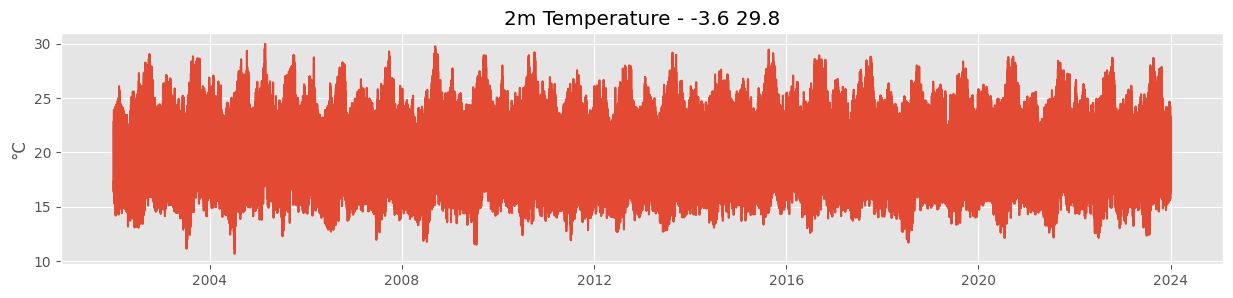

In [9]:
temp = pd.DataFrame(df_era5['t2m'] - 273.15)
temp = create_timefeatures(temp)

plt.figure(figsize=[15,3])
plt.title(f'2m Temperature - {lat_era5} {lon_era5}')
plt.ylabel('°C')
plt.plot(temp.t2m)
plt.show()

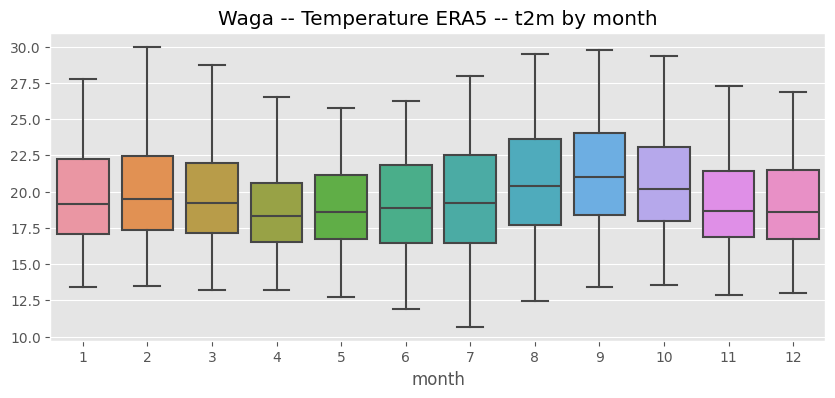

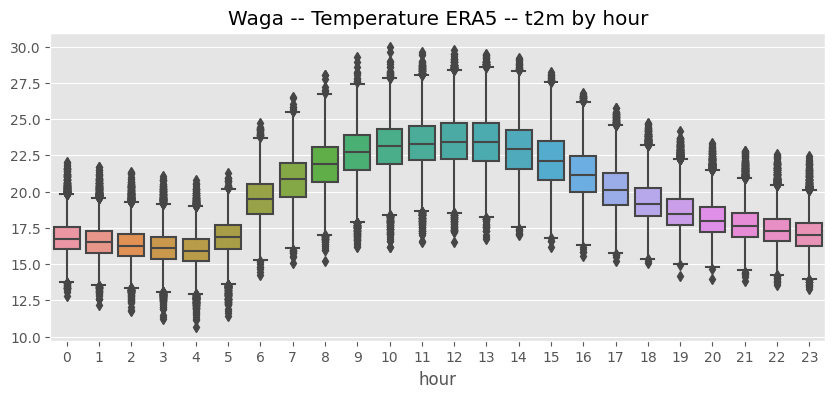

In [10]:
feature_target_relation(temp, key='t2m', feature='month', location='Waga', name='Temperature ERA5')
feature_target_relation(temp, key='t2m', feature='hour', location='Waga', name='Temperature ERA5')

### Evaporation

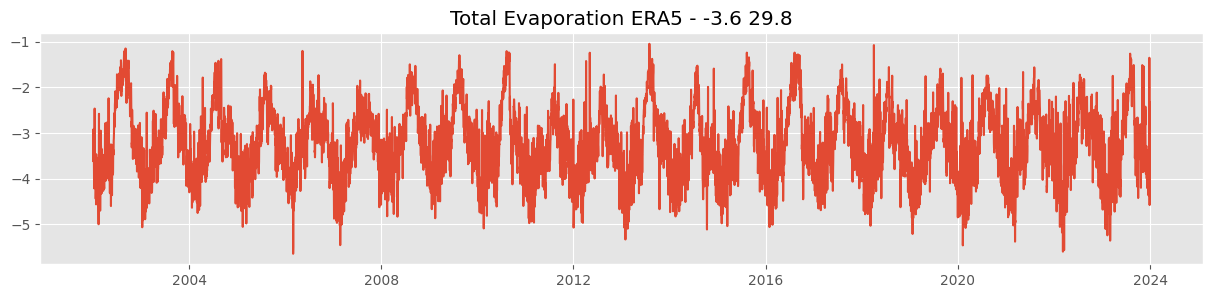

In [11]:
evap = df_era5['e'].diff()
evap = create_timefeatures(pd.DataFrame(evap))
evap['e'][evap['hour']==1] = df_era5['e'][df_era5['hour']==1]
evap.e = evap.e * 11000 * 11000 / 60 / 60
evap = evap.groupby(pd.Grouper(freq='1D')).mean()
evap = evap.dropna()

plt.figure(figsize=[15,3])
plt.title(f'Total Evaporation ERA5 - {lat_era5} {lon_era5}')
# plt.ylabel('°C')
plt.plot(evap.e)
plt.show()

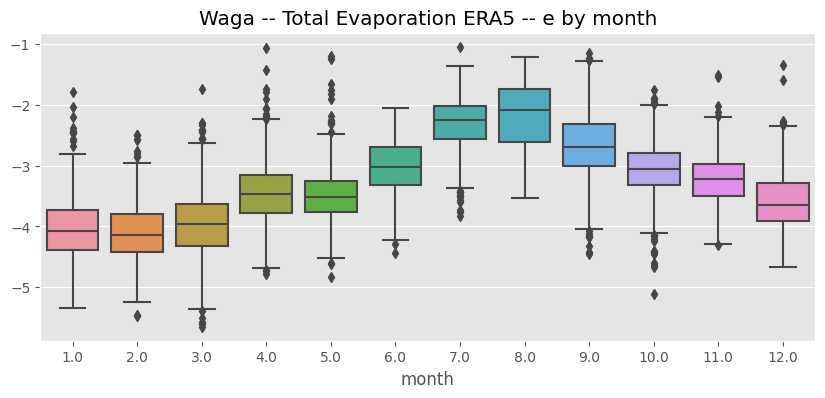

In [12]:
feature_target_relation(evap, location='Waga', name='Total Evaporation ERA5', key='e', feature='month')

### Solar

In [13]:
try:
    read_nc('./data/ERA5/Waga-Solar_ERA5_' + '2015' + '_' + '01' + '.nc', info=True)
except:
    read_nc('./data/ERA5/Waga-Solar_ERA5_' + '2015' + '_' + '1' + '.nc', info=True)


DATASET----------------------------------------------------------------------------------------------------
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    history: 2024-11-18T13:10 GRIB to CDM+CF via cfgrib-0.9.14.1/ecCodes-2.36.0 with {"source": "data.grib", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
    dimensions(sizes): valid_time(744), latitude(4), longitude(3)
    variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 ssr(valid_time, latitude, longitude), float32 str(valid_time, latitude, longitude), float32 ssrd(valid_time, latitude, longitude), float32 strd(valid_time, lat


DATASET----------------------------------------------------------------------------------------------------
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    history: 2024-11-20T23:26 GRIB to CDM+CF via cfgrib-0.9.14.1/ecCodes-2.36.0 with {"source": "data.grib", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
    dimensions(sizes): valid_time(744), latitude(4), longitude(3)
    variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 ssr(valid_time, latitude, longitude), float32 str(valid_time, latitude, longitude), float32 ssrd(valid_time, latitude, longitude), float32 strd(valid_time, lat

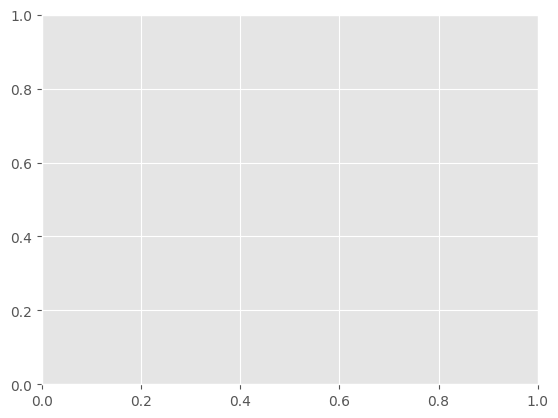

In [14]:
df_era5_solar, lat_era5_solar, lon_era5_solar = load_ERA5(
    lat_index=2,
    lon_index=1,
    months=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    years=[str(year) for year in range(2006, 2024)],
    plot_nc=plot_nc,
    plant_name='Waga-Solar'
)

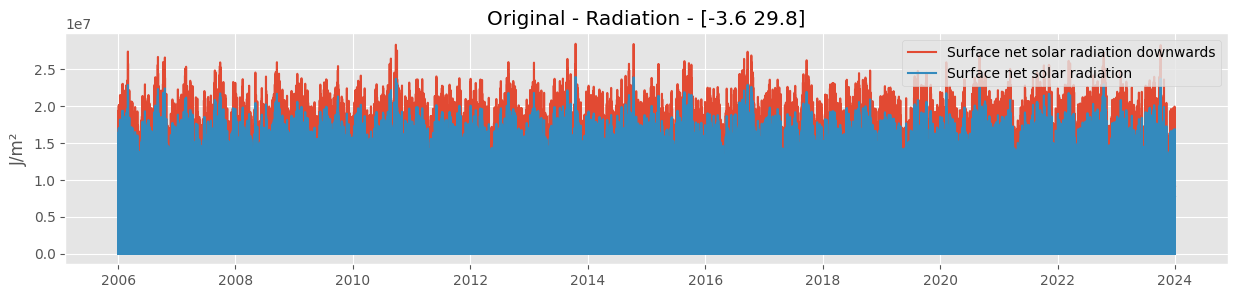

In [15]:
## ORIGINAL DATA
%matplotlib inline
plt.figure(figsize=[15,3])
plt.plot(df_era5_solar['ssrd'], label='Surface net solar radiation downwards')

plt.plot(df_era5_solar['ssr'], label='Surface net solar radiation')

plt.ylabel('J/m²')
plt.title(f'Original - Radiation - [{lat_era5_solar} {lon_era5_solar}]')
plt.legend()
plt.show()

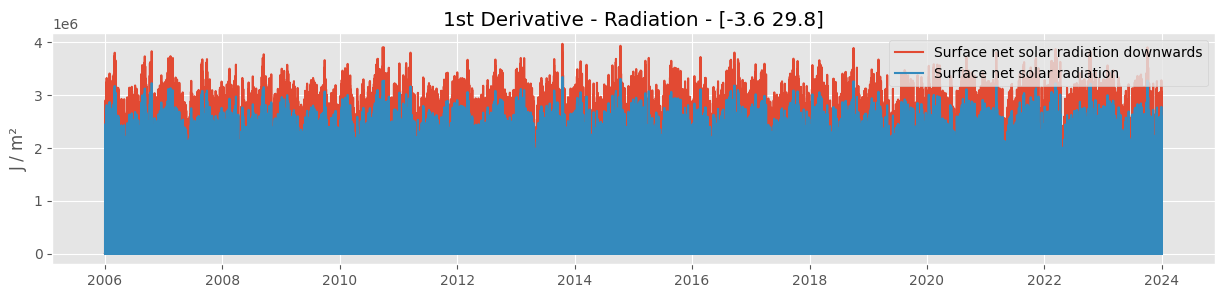

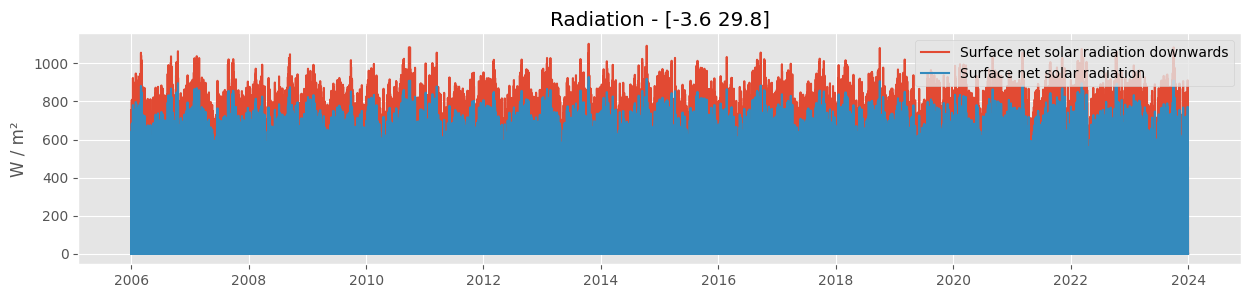

In [27]:
%matplotlib inline
# HOURLY DERIVATIVE DOWNWARDS
ssrd = df_era5_solar['ssrd'].diff()
ssrd = create_timefeatures(pd.DataFrame(ssrd))
ssrd['ssrd'][ssrd['hour']==1] = df_era5_solar['ssrd'][df_era5_solar['hour']==1]
ssrd = create_timefeatures(pd.DataFrame(ssrd))
# ssrd = ssrd.dropna()
ssrd = ssrd.fillna(0)

# HOURLY DERIVATIVE
ssr = df_era5_solar['ssr'].diff()
ssr = create_timefeatures(pd.DataFrame(ssr))
ssr['ssr'][ssr['hour']==1] = df_era5_solar['ssr'][df_era5_solar['hour']==1]
ssr = create_timefeatures(pd.DataFrame(ssr))
# ssr = ssr.dropna()
ssr = ssr.fillna(0)

plt.figure(figsize=[15,3])
plt.plot(ssrd.ssrd, label='Surface net solar radiation downwards')
plt.plot(ssr.ssr, label='Surface net solar radiation')
plt.ylabel('J / m²')
plt.legend()
plt.title(f'1st Derivative - Radiation - [{lat_era5_solar} {lon_era5_solar}]')
plt.show()

plt.figure(figsize=[15,3])
plt.plot(ssrd.ssrd / 3_600, label='Surface net solar radiation downwards')
plt.plot(ssr.ssr / 3_600, label='Surface net solar radiation')
plt.ylabel('W / m²')
plt.legend()
plt.title(f'Radiation - [{lat_era5_solar} {lon_era5_solar}]')
plt.show()

In [17]:
## PRODUCTION IN 2015
%matplotlib inline
lowcut = 300 # W/m²
year = 2020
rating = 0.15088 # MW
sunlighthours_api = 1060.1838 # http://www.smartsolar-tanzania.com/solar-sector-information/solar-power-potential-tanzania/

## MAX SUNSHINE HOURS PER YEAR
print(f'\n{"":-^100}')
print('Sunlight\n')
print(f'Hours in a year:\t\t{365*24} h')
sunlighthours = len(ssrd.ssrd[(ssrd.ssrd > 0) & (ssrd.year==year)])
print(f'Hours with data > 0:\t\t{sunlighthours} h')
productionhours = len(ssrd.ssrd[((ssrd.ssrd/3_600) > lowcut) & (ssrd.year==year)]) # Lowcut on 300 W/m²
print(f'Hours with data > {lowcut} W/m²:\t{productionhours} h')

## SITE POTENTIAL
print(f'\n{"":-^100}')
print('Site potential')
print('')
print(f'SmartSolar Sunlight hours:\t{int(sunlighthours_api)} h')
print(f'Rating:\t\t\t\t{rating} MW')
print(f'\033[1mPotential:\t\t\t{round(rating*sunlighthours_api,2)} MWh\033[0m')

## ERA5 POTENTIAL
print(f'\n{"":-^100}')
print('ERA5')
print('')
area = 718.61
prod_sum = np.sum(ssrd.ssrd[((ssrd.ssrd/3_600) > lowcut) & (ssrd.year==year)]) / 3_600_000 * area # kWh * area
print(f'Potential (> 300 W/m²):\t\t{round(prod_sum/1000, 2)} MWh')
print(f'Nutzungsgrad:\t\t\t{round((rating*sunlighthours_api) / (prod_sum/1000) *100,2)}%')

print(f'\n{"":-^100}')
SmartSolar = 4*365*718.61/1000
print(f'Theoretical output according to SmartSolar Tanzania\n')
print('Low')
print(f'4kWh/m² * 365d * 718.61m² / 1000\n= {round(SmartSolar,2)} mWh/Y')
print(f'Nutzungsgrad:\t\t\t{round((rating*sunlighthours_api) / (SmartSolar) *100,2)}%')
SmartSolar = 7*365*718.61/1000
print('High')
print(f'7kWh/m² * 365d * 718.61m² / 1000\n= {round(SmartSolar,2)} mWh/Y')
print(f'Nutzungsgrad:\t\t\t{round((rating*sunlighthours_api) / (SmartSolar) *100,2)}%')


plt.plot(ssrd.ssrd[ssrd.year==year] / 3_600_000) # kW/m²


----------------------------------------------------------------------------------------------------
Sunlight

Hours in a year:		8760 h
Hours with data > 0:		4701 h
Hours with data > 300 W/m²:	2730 h

----------------------------------------------------------------------------------------------------
Site potential

SmartSolar Sunlight hours:	1060 h
Rating:				0.15088 MW
Potential:			159.96 MWh

----------------------------------------------------------------------------------------------------
ERA5

Potential (> 300 W/m²):		1113.22 MWh
Nutzungsgrad:			14.37%

----------------------------------------------------------------------------------------------------
Theoretical output according to SmartSolar Tanzania

Low
4kWh/m² * 365d * 718.61m² / 1000
= 1049.17 mWh/Y
Nutzungsgrad:			15.25%
High
7kWh/m² * 365d * 718.61m² / 1000
= 1836.05 mWh/Y
Nutzungsgrad:			8.71%


pomm_helper main run


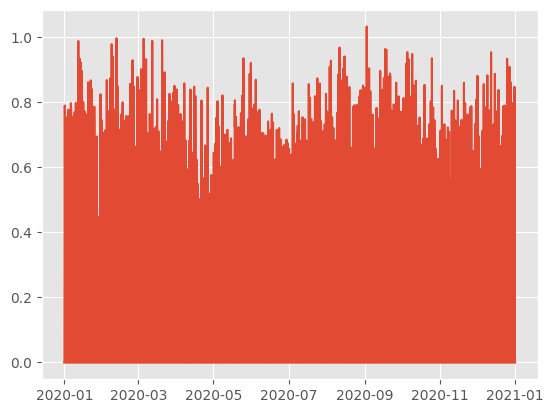

ERA5 sum (> 300 W/m²):		1113.22 MWh
Discounted:			1113.22 MWh
AOI filtered:			1113.22 MWh	0.0 %
Elevation filtered:		1110.12 MWh	0.28 %
Azimuth filtered:		422.33 MWh	62.06 %
Combined:			420.59 MWh



<Figure size 640x480 with 0 Axes>

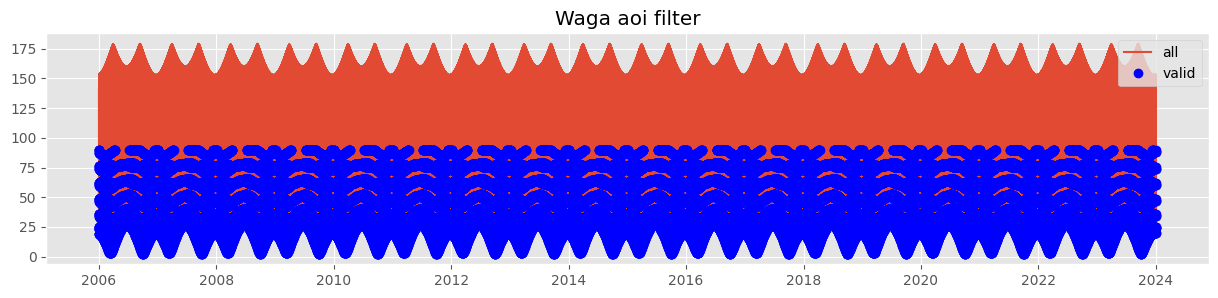

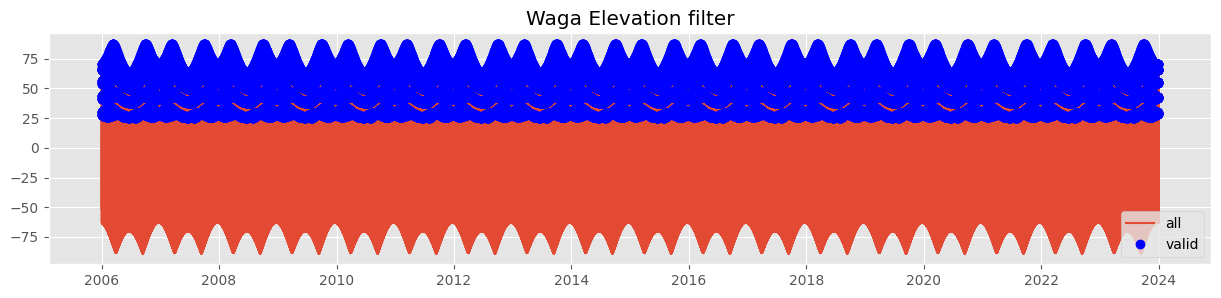

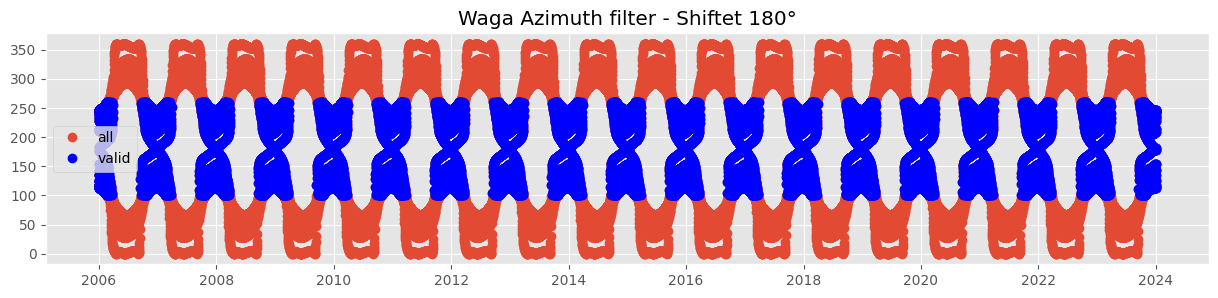

ERA5 sum (> 300 W/m²):		879.6 MWh
Discounted:			879.6 MWh
AOI filtered:			879.6 MWh	0.0 %
Elevation filtered:		878.9 MWh	0.08 %
Azimuth filtered:		334.69 MWh	61.95 %
Combined:			334.0 MWh



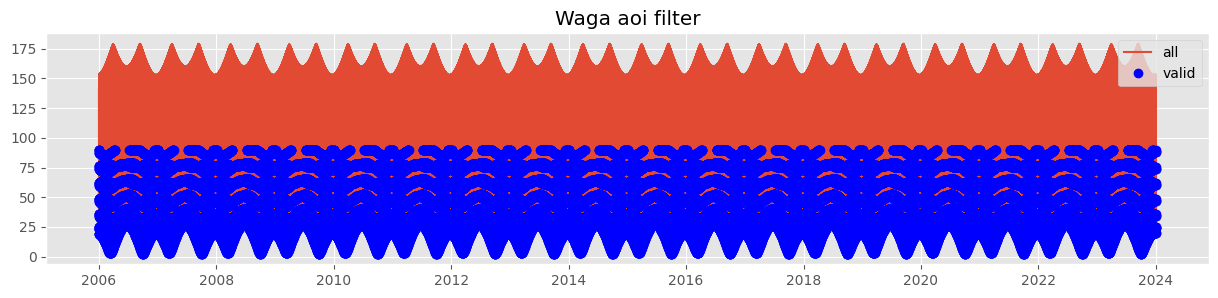

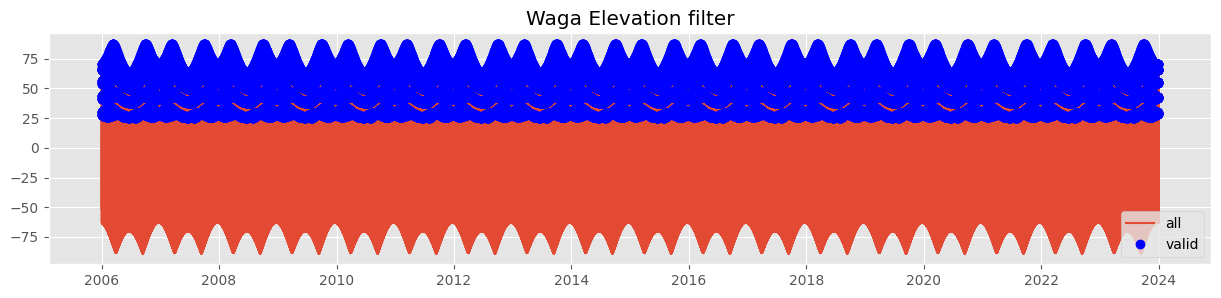

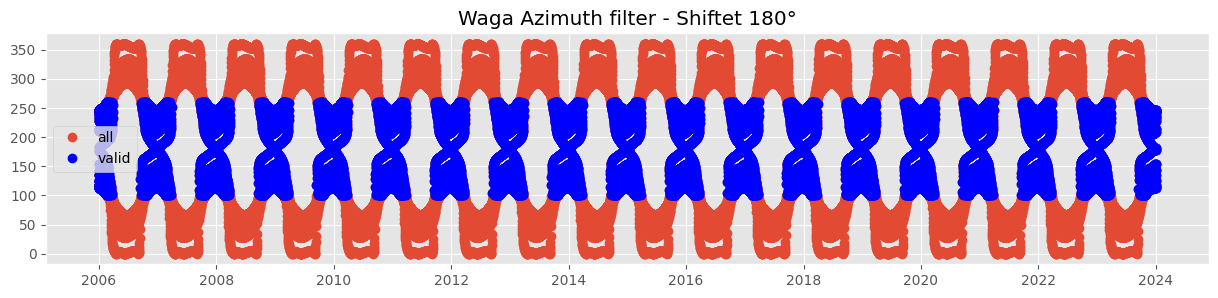

In [18]:
%run ./pomm/pomm_helper.py
f_aoi = 90
f_elevation = 25 # 25 ; Switzerland --> 15
f_azimuth = [100,260] # [100, 260] (180=South) ; Switzerland --> [140, 220]
shift_180 = False
plot = True
angles_filter(ssrd, 'ssrd', 'Waga', 1.0, lowcut, year, lat_era5_solar, lon_era5_solar, area, f_aoi=f_aoi, f_elevation=f_elevation, f_azimuth=f_azimuth, plot=plot, shift_180=shift_180)
angles_filter(ssr, 'ssr', 'Waga', 1.0, lowcut, year, lat_era5_solar, lon_era5_solar, area, f_aoi=f_aoi, f_elevation=f_elevation, f_azimuth=f_azimuth, plot=plot, shift_180=shift_180)

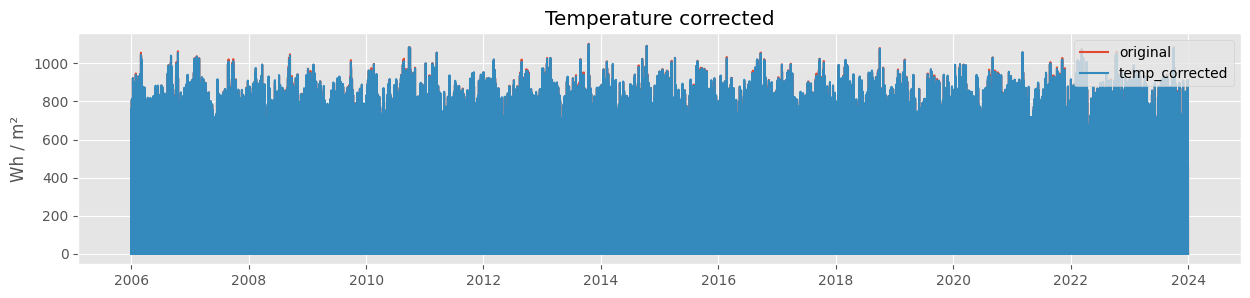

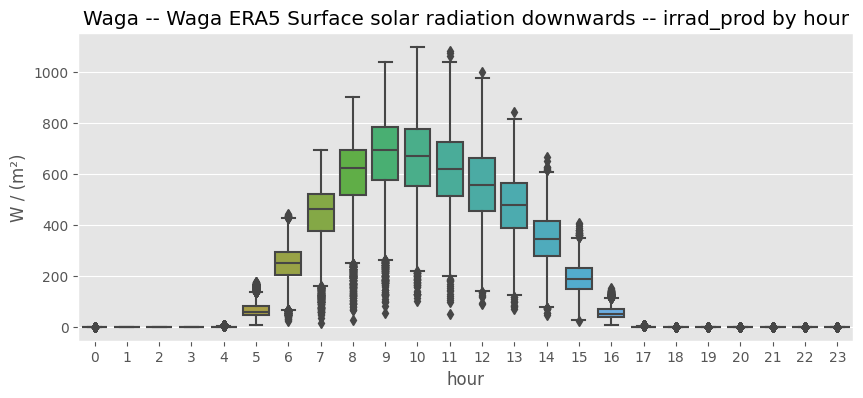

In [19]:
## TEMPERATURE CORRECTION
%matplotlib inline
MPT_k = 0.004
C_k = +MPT_k * (temp.t2m - 25)
ssrd['irrad_prod'] = (ssrd.ssrd/3_600) * (1-C_k)
plt.figure(figsize=[15,3])
plt.title(f'Temperature corrected')
plt.ylabel('Wh / m²')
plt.plot((ssrd.ssrd/3_600), label='original')
plt.plot(ssrd.irrad_prod, label='temp_corrected')
plt.legend()
plt.show()

feature_target_relation(ssrd, key='irrad_prod', feature='hour', location='Waga', name='Waga ERA5 Surface solar radiation downwards', ylabel='W / (m²)')

pomm_vis main run
Mean production on monthly sum: 92488.6328125
Yearly sum (area under the curve): 1113223.5
Yearly sum with ratio correction: 1113223.5


<Figure size 640x480 with 0 Axes>

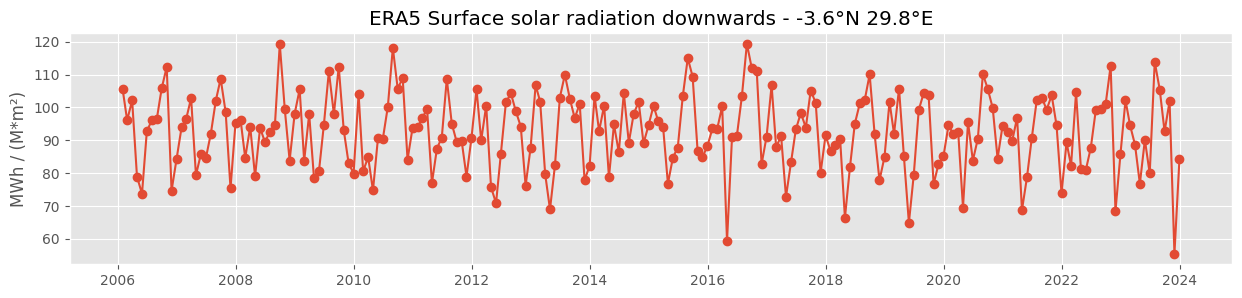

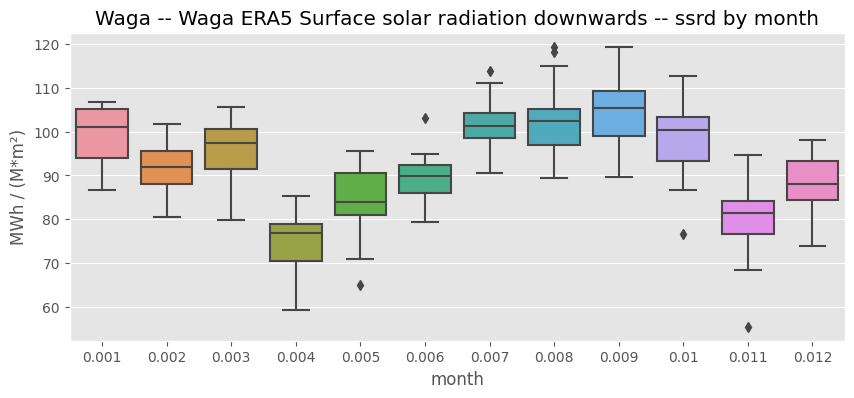

In [20]:
# CONVERT TO MONTHLY kwh/m²
%run ./pomm/pomm_vis.py
ssrd_monthly = ssrd[(ssrd.ssrd/3_600) > 300].copy()
ssrd_monthly = pd.DataFrame(ssrd_monthly['ssrd']/3_600)
ssrd_monthly = ssrd_monthly.groupby(pd.Grouper(freq='1M')).sum() / 1_000
ssrd_monthly = create_timefeatures(ssrd_monthly)

## MULTIPLY BY AREA OF INTEREST
m_factor = area # scenario_1
ssrd_monthly.ssrd *= m_factor
print(f'Mean production on monthly sum: {round(ssrd_monthly.ssrd.mean(), 2)}')
print(f'Yearly sum (area under the curve): {round(ssrd_monthly.ssrd[ssrd_monthly.year==year].sum(), 2)}')
print(f'Yearly sum with ratio correction: {round(ssrd_monthly.ssrd[ssrd_monthly.year==year].sum() * 1.0, 2)}')

plt.figure(figsize=[15,3])
plt.title(f'ERA5 Surface solar radiation downwards - {lat_era5_solar}°N {lon_era5_solar}°E')
plt.plot(ssrd_monthly.ssrd*1.0/1000, '-o')
plt.ylabel('MWh / (M*m²)')
plt.plot()

feature_target_relation(ssrd_monthly*1.0/1000, key='ssrd', feature='month', location='Waga', name='Waga ERA5 Surface solar radiation downwards', ylabel='MWh / (M*m²)')

In [21]:
# ------------------------------------------------------------------------------ TEMPERATURE CORRECTED
# CONVERT TO MONTHLY kwh/m²
ssrd_monthly = ssrd[(ssrd.ssrd/3_600) > 300].copy()
ssrd_monthly = pd.DataFrame(ssrd_monthly['irrad_prod'])
ssrd_monthly = ssrd_monthly.groupby(pd.Grouper(freq='1M')).sum() / 1_000
ssrd_monthly = create_timefeatures(ssrd_monthly)

## MULTIPLY BY AREA OF INTEREST
m_factor = area # scenario_1
ssrd_monthly.irrad_prod *= m_factor * 1.0
print(f'Mean production on monthly sum: {round(ssrd_monthly.irrad_prod.mean(), 2)}')
print(f'Yearly sum (area under the curve): {round(ssrd_monthly.irrad_prod[ssrd_monthly.year==year].sum(), 2)}')
print(f'Yearly sum with ratio correction: {round(ssrd_monthly.irrad_prod[ssrd_monthly.year==year].sum() * 1.0, 2)}')

plt.figure(figsize=[15,3])
plt.title(f'ERA5 Surface solar radiation downwards - {lat_era5_solar}°N {lon_era5_solar}°E')
plt.plot(ssrd_monthly.irrad_prod/1000, '-o')
plt.ylabel('MWh / (M*m²)')
plt.plot()

Mean production on monthly sum: 93186.59375
Yearly sum (area under the curve): 1120873.625
Yearly sum with ratio correction: 1120873.62


[]

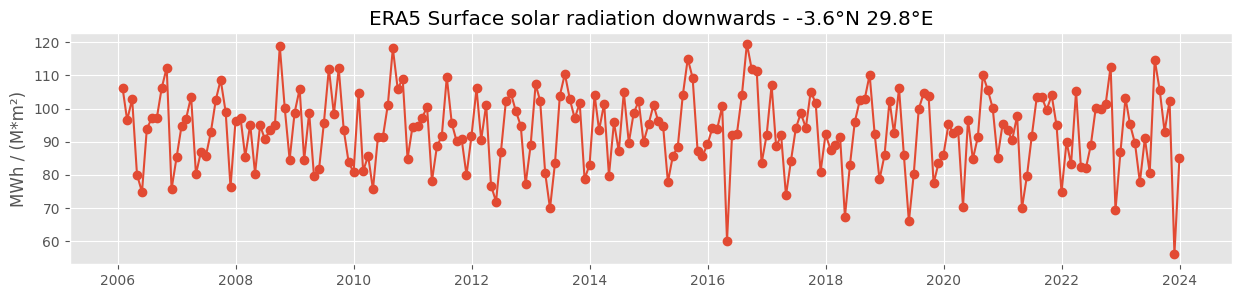

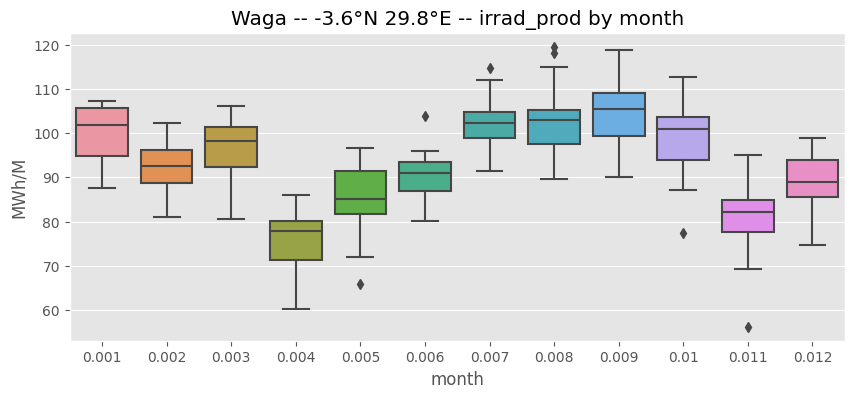

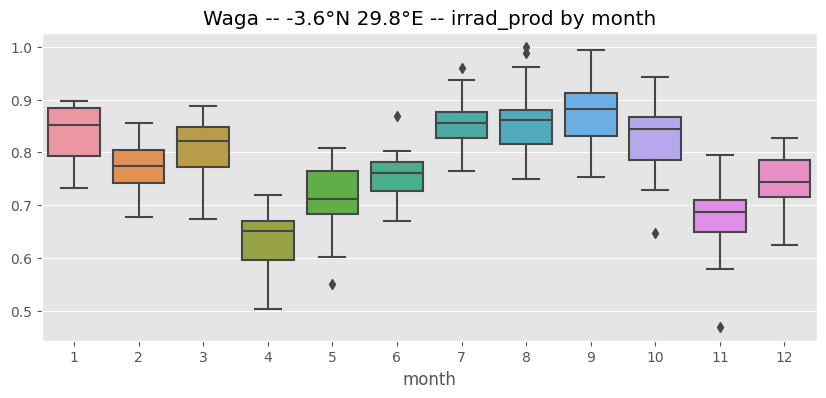

In [22]:
## MULTIPLY BY SUNHOURS FACTOR
ssrd_monthly.irrad_prod = ssrd_monthly.irrad_prod
feature_target_relation(ssrd_monthly/1000, key='irrad_prod', feature='month', location='Waga', name=f'{lat_era5}°N {lon_era5}°E', ylabel='MWh/M')
ssrd_monthly.irrad_prod = ssrd_monthly.irrad_prod / ssrd_monthly.irrad_prod.max()
feature_target_relation(ssrd_monthly, key='irrad_prod', feature='month', location='Waga', name=f'{lat_era5}°N {lon_era5}°E', ylabel='')

In [26]:
## EXPORT
ssrd_monthly.to_excel(p.output + 'Waga_dist_normalized_1.xlsx')

## Real world vs Remote Sensing

In [ ]:
compare = waga_concat.copy()
compare = compare.merge(pd.DataFrame(tp.tp), how='left', left_index=True, right_index=True)
compare = compare.merge(pd.DataFrame(waga_nkondo_concat['runoff']), how='left', left_index=True, right_index=True)
compare = compare.merge(pd.DataFrame(ro.ro), how='left', left_index=True, right_index=True)
compare

In [ ]:
%matplotlib inline
plt.figure(figsize=[20,5])
plt.plot(compare['GISOZI'], alpha=0.5, label='GISOZI')
plt.plot(compare['GITEGA (Aerodrome)'], alpha=0.5, label='GITEGA')
plt.plot(compare['RUVYIRONZA'], alpha=0.5, label='RUVYIRONZA')
plt.plot(compare['tp'], label='Remote Sensing')
plt.title('Rainfall - Real World vs Remote Sensing (ERA5)')
plt.legend()

## SAVE PLOT
mydir = './output/plots/'
name = mydir + 'Rainfall - Real World vs Remote Sensing (ERA5)' + '.png'
if not os.path.isdir(mydir):
    print(f'Creating folder {mydir}')
    os.mkdir(mydir)
plt.savefig(name)

plt.show()

In [ ]:
%matplotlib inline
plt.plot(compare['runoff'], label='Measured')
plt.plot(compare['ro'], alpha=0.5, label='Remote Sensing')
plt.title('Discharge - Real World vs Remote Sensing (ERA5)')
plt.legend()

## SAVE PLOT
mydir = './output/plots/'
name = mydir + 'Discharge - Real World vs Remote Sensing (ERA5)' + '.png'
if not os.path.isdir(mydir):
    print(f'Creating folder {mydir}')
    os.mkdir(mydir)
plt.savefig(name)

plt.show()

# MODEL

## Generate input

In [ ]:
waga_concat.RUVYIRONZA

In [ ]:
df_merged = pd.DataFrame(waga_nkondo_concat.runoff).merge(pd.DataFrame(waga_concat.RUVYIRONZA), how='inner', left_index=True, right_index=True)
df_merged.columns = ['runoff', 'rainfall']
df_merged = create_timefeatures(df_merged)
df_merged


In [ ]:
plot_rainfall_runoff(df=df_merged, rain='rainfall', runoff='runoff', plot_title='Ruvironza - Input')

## Model

In [77]:
terrain_3d(
    elevation=p.elevation_cutted*p.catchment_cutted,
    mode='mesh',
    # textures=[p.elevation_cutted, p.flowdir_cutted, p.accumulation_v_cutted, p.rs_v, p.steps_to_intake, p.distance_to_intake/1000, p.soil_v_cutted, p.CN_init, p.Sabs_init, p.mc_overland, p.mc_subsurface]
    textures=[p.elevation_cutted, p.flowdir_cutted, p.accumulation_v_cutted]
)

In [61]:
p.CN_init = np.nan_to_num(p.CN_init, nan=1)
p.Sabs_init = np.nan_to_num(p.Sabs_init, nan=1)
p.mc_overland = np.nan_to_num(p.mc_overland, nan=1)
p.mc_subsurface = np.nan_to_num(p.mc_subsurface, nan=1)

In [62]:
# Adjust elevation around so we make sure the pixxels within catchment are not flowing outside the catchment
p.elevation_cutted[p.catchment_cutted==0.0] *= 10

In [63]:
precip = np.array(df_merged['rainfall']) /30
precip = np.nan_to_num(precip, nan=0.0)
precip[50:] = 0 # Rain only in the beginning for later gif visualization

In [ ]:
T = 4000
evap_month = np.array(df_merged.month)
water_storage, soil_storage, Q_water, Q_soil, water_tot, soil_tot, CN, V_water, V_soil, S = p.pomm_runoff(
    ## Rainfall
    precip=precip,
    ## GeoSpacial
    catchment=p.catchment_cutted,
    elevation=p.elevation_cutted,
    spatial_res=p.spatial_res,
    flowdir=p.flowdir_cutted,
    x_min=p.x_min,
    x_max=p.x_max,
    y_min=p.y_min,
    y_max=p.y_max,
    T=T,
    intake_x=p.intake_x,
    intake_y=p.intake_y,
    ## Pomm Specific
    CN_init=p.CN_init,
    Sabs_init=p.Sabs_init,
    mc_overland=p.mc_overland,
    mc_subsurface=p.mc_subsurface,
    evap_factors=[1]*12,
    evap_month=evap_month,
    # evapo=0.75,
    # max_shift=1000,
    # evapo_temperature=[1],
    ## Checkpoint
    water=np.zeros((p.x_max-p.x_min,p.y_max-p.y_min), dtype=np.float32),
    soil=np.zeros((p.x_max-p.x_min,p.y_max-p.y_min), dtype=np.float32),
    Q_water=np.zeros((p.x_max-p.x_min,p.y_max-p.y_min), dtype=np.float32),
    Q_soil=np.zeros((p.x_max-p.x_min,p.y_max-p.y_min), dtype=np.float32),
    V_water=np.zeros((p.x_max-p.x_min,p.y_max-p.y_min), dtype=np.float32),
    V_soil=np.zeros((p.x_max-p.x_min,p.y_max-p.y_min), dtype=np.float32)
)

In [ ]:
plot_tensor(water_storage)

In [ ]:
%matplotlib inline
plt.imshow(water_storage[-1])
plt.show()

In [67]:
df_merged['model'] = np.zeros(df_merged.shape[0])
df_merged['model'][:T+1] = water_storage[:, 120, 590] * 20
df_merged['validation'] = np.nan_to_num(df_merged['runoff'], nan=df_merged['runoff'].min())

In [ ]:
%matplotlib inline
nse = calc_nse(mod=df_merged.model[400:T+1], val=df_merged.validation[400:T+1])
plt.plot(df_merged.validation[:T+1], label='Validation')
plt.plot(df_merged.model[:T+1], label='Model')
plt.title(f'NSE: {round(nse,3)}')
plt.legend()
plt.show()

In [ ]:
%run ./pomm/pomm_vis.py
plot_rainfall_runoff(df=df_merged[365:T+1], rain='rainfall', runoff='validation', model='model', plot_title=f'Ruvironza - Model (NSE: {round(nse,3)})')

In [ ]:
df_merged[['validation', 'model']]

In [ ]:
plot_fdc(df=df_merged[365:T+1], key='validation', title='FDC Ruvironza')
plot_fdc(df=df_merged[365:T+1], key='model', title='FDC Model')
plot_fdc(df=df_merged[['validation', 'model']][365:T+1], title='FDC - Model vs Valid')

# Export

In [ ]:
import imageio
import os

# Pfad zum Ordner mit den PNG-Dateien
ordner_pfad = './output/plots/gif'

# Liste aller PNG-Dateien im Ordner sortiert nach Dateinamen
bilder_dateien = sorted([datei for datei in os.listdir(ordner_pfad) if datei.endswith('.png')])

# Erstelle eine Liste der Bilddaten
bilder = []
for i, datei in enumerate(bilder_dateien[:2000]):
    if not i % 20:
        bild_pfad = os.path.join(ordner_pfad, datei)
        bilder.append(imageio.imread(bild_pfad))

# Erstelle und speichere das GIF
gif_pfad = './output/waga_gif.gif'
imageio.mimsave(gif_pfad, bilder, duration=0.01)  # Dauer pro Frame in Sekunden

print(f"GIF gespeichert als {gif_pfad}")